In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import h3
import numpy as np
import matplotlib.pyplot as plt

In [2]:
comuna = gpd.read_file('./data/comunas')
comuna = comuna[comuna['Comuna']=='Talcahuano']
comuna.to_crs('4326', inplace=True)

In [3]:
def make_grid_points_gdf(gdf, x_spacing, y_spacing):
    gdf = gdf.copy()
    if gdf.crs is None:
        gdf.crs = 'EPSG:4326'
    gdf.to_crs('32718', inplace=True)

    xmin, ymin, xmax, ymax = gdf.total_bounds
    xcoords = [c for c in np.arange(xmin, xmax, x_spacing)]
    ycoords = [c for c in np.arange(ymin, ymax, y_spacing)]

    coordinate_pairs = np.array(np.meshgrid(xcoords, ycoords)).T.reshape(-1, 2)
    geometries = gpd.points_from_xy(coordinate_pairs[:,0], coordinate_pairs[:,1])

    pointdf = gpd.GeoDataFrame(geometry=geometries, crs=gdf.crs)

    pointdf.to_crs('4326', inplace=True)
    return pointdf

x_spacing = 50
y_spacing = 50
grid_points = make_grid_points_gdf(comuna, x_spacing, y_spacing)

<Axes: >

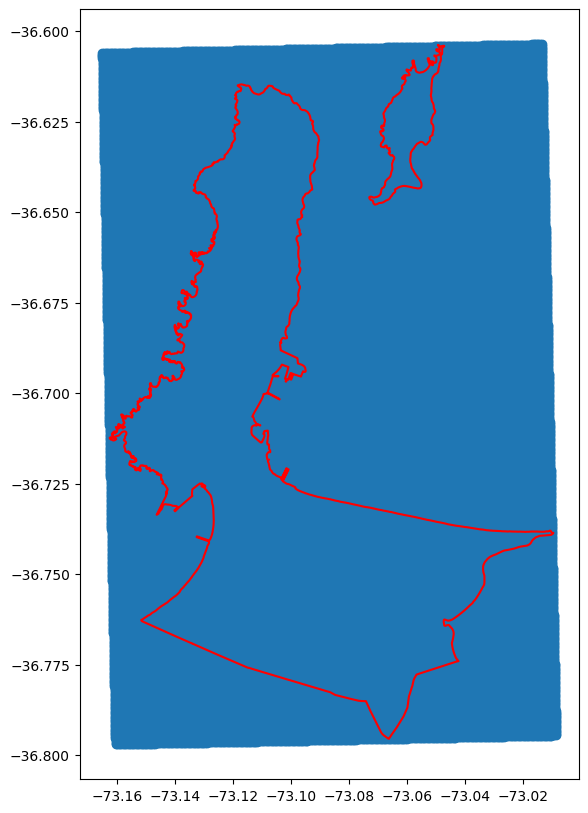

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
grid_points.plot(ax = ax)
comuna.boundary.plot(ax = ax, color='red')

In [5]:
grid_points = gpd.overlay(grid_points, comuna[['geometry']], how='intersection')

<Axes: >

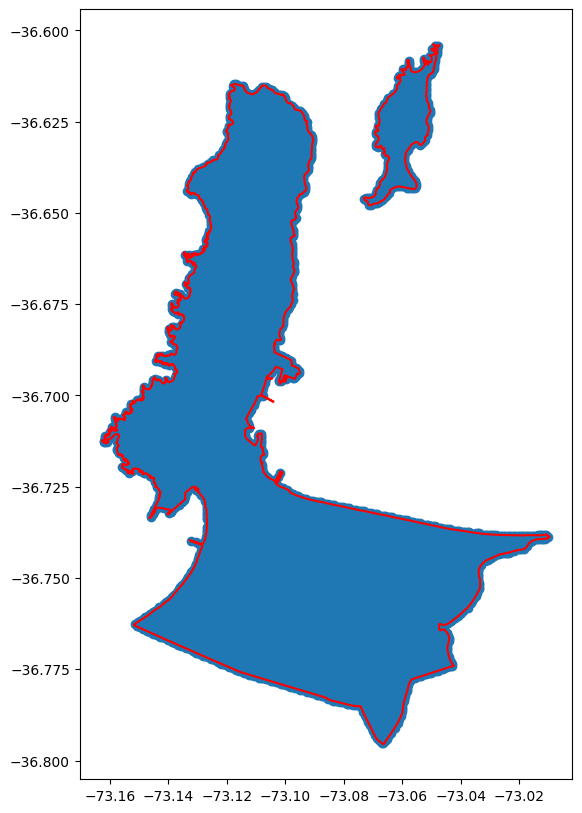

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
grid_points.plot(ax = ax)
comuna.boundary.plot(ax = ax, color='red')

In [118]:
APERTURE_SIZE = 10
hex_col = f'hex{APERTURE_SIZE}'

grid_points[hex_col] = grid_points.apply(lambda p: h3.latlng_to_cell(p.geometry.y,p.geometry.x,APERTURE_SIZE),1)

In [119]:
hex_list = grid_points[[hex_col]].drop_duplicates().reset_index(drop=True)

In [120]:
from shapely.geometry import Polygon

# Función para convertir código H3 a un polígono de Shapely
def h3_to_polygon(hex_code):
    boundary = h3.cell_to_boundary(hex_code)
    boundary_corrected = [(lat, lon) for lon, lat in boundary]
    return Polygon(boundary_corrected)

# Crear una nueva columna en el DataFrame con la geometría de cada hexágono
hex_list['geometry'] = hex_list[hex_col].apply(h3_to_polygon)

# Convertir el DataFrame en un GeoDataFrame
hex_list = gpd.GeoDataFrame(hex_list, geometry='geometry')
hex_list.crs = 'EPSG:4326'

hex_list.to_crs('32718', inplace=True)
hex_list['area_hex'] = hex_list.area
hex_list.to_crs('4326', inplace=True)

<Axes: >

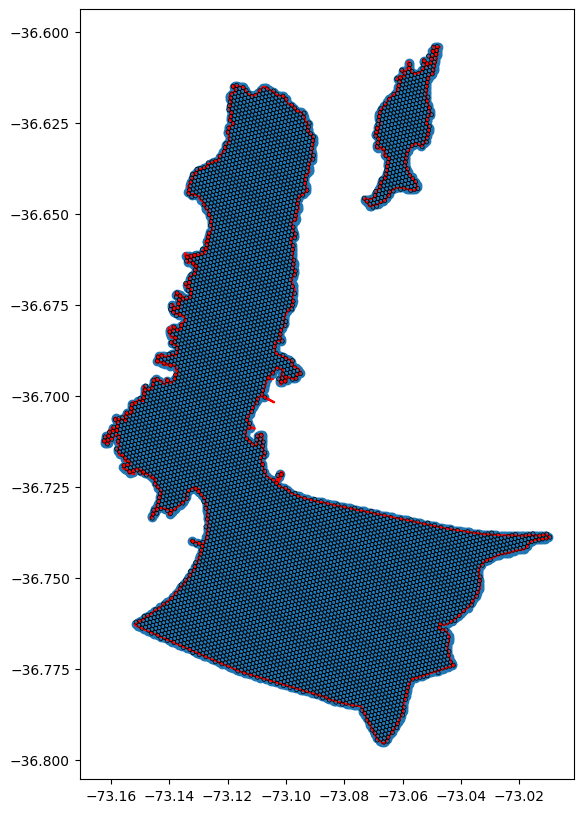

In [121]:
fig, ax = plt.subplots(figsize=(10,10))
grid_points.plot(ax = ax)
comuna.boundary.plot(ax = ax, color='red')
hex_list.boundary.plot(ax = ax, color='black', alpha=1, edgecolor='black', linewidth=0.5, facecolor='none')

In [122]:
land_uses = gpd.read_file('./data/usos_suelo_sii')
land_uses.to_crs('4326', inplace=True)
land_uses.to_crs('32718', inplace=True)
lu_cols = ['id', 'COD_DESTIN', 'DESTINO', 'geometry']
land_uses = land_uses[lu_cols]
land_uses['area_predio'] = land_uses.area
land_uses.to_crs('4326', inplace=True)

<Axes: >

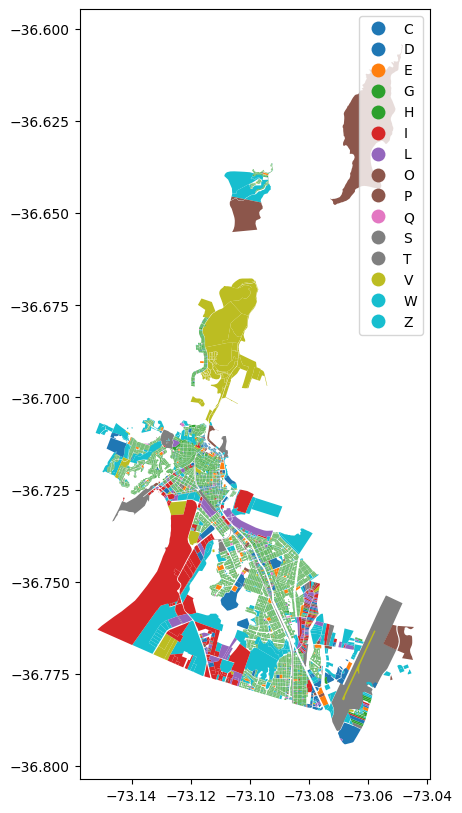

In [123]:
land_uses.plot(column='COD_DESTIN', legend=True, figsize=(10,10))

In [124]:
gdf_overlay = gpd.overlay(hex_list, land_uses, how='intersection', keep_geom_type=False)

In [125]:
gdf_overlay.to_crs('32718', inplace=True)
gdf_overlay['area_interseccion'] = gdf_overlay.area
gdf_overlay.to_crs('4326', inplace=True)

In [127]:
gdf_group_by_use = gdf_overlay.groupby([hex_col, 'COD_DESTIN']).agg({'area_interseccion':'sum'}).reset_index().rename(columns={'area_interseccion': 'area_by_use'})
gdf_group_by_hex = gdf_overlay.groupby([hex_col]).agg({'area_interseccion':'sum'}).reset_index().rename(columns={'area_interseccion': 'area_used_by_hex'})

In [128]:
gdf_group = pd.merge(gdf_group_by_hex, gdf_group_by_use, on=hex_col, how='left')

In [129]:
gdf_group['fraction_by_use'] = gdf_group['area_by_use'] / gdf_group['area_used_by_hex']

In [130]:
gdf_group['info_by_use'] = -1*gdf_group['fraction_by_use']*np.log2(gdf_group['fraction_by_use'])
gdf_group.loc[gdf_group['fraction_by_use']==1, 'info_by_use'] = 0

In [131]:
gdf_group = gdf_group[[hex_col, 'info_by_use']].groupby(hex_col).agg({'info_by_use':'sum'}).reset_index().rename(columns={'info_by_use': 'diversity'})

In [132]:
gdf_diversity = pd.merge(gdf_group, hex_list, on=hex_col)
gdf_diversity.drop(columns=['area_hex'], inplace=True)
gdf_diversity = gpd.GeoDataFrame(gdf_diversity, geometry='geometry')

<Axes: >

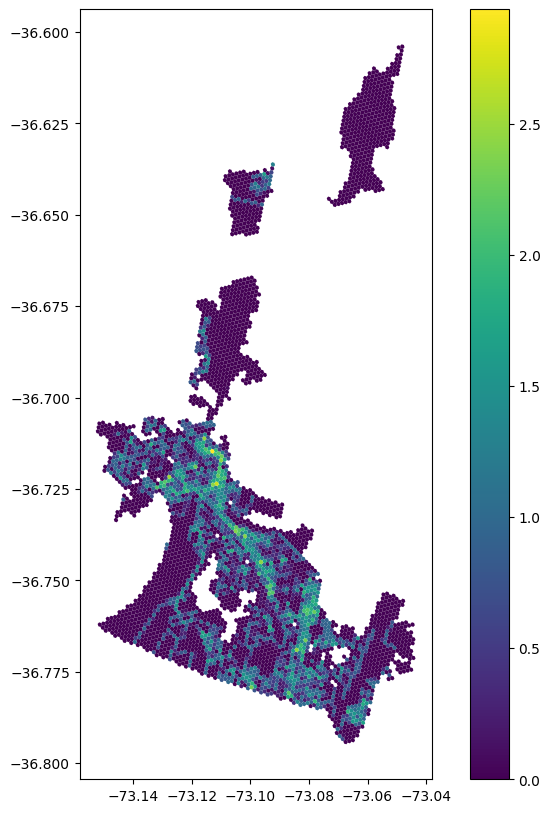

In [133]:
gdf_diversity.plot(column='diversity', legend=True, figsize=(10,10))

In [134]:
missing_hexs = hex_list.loc[~hex_list[hex_col].isin(gdf_diversity[hex_col]), [hex_col, 'geometry']]
missing_hexs['diversity'] = 0

In [135]:
gdf_diversity = pd.concat([gdf_diversity, missing_hexs])
gdf_diversity = gpd.GeoDataFrame(gdf_diversity, geometry='geometry')

<Axes: >

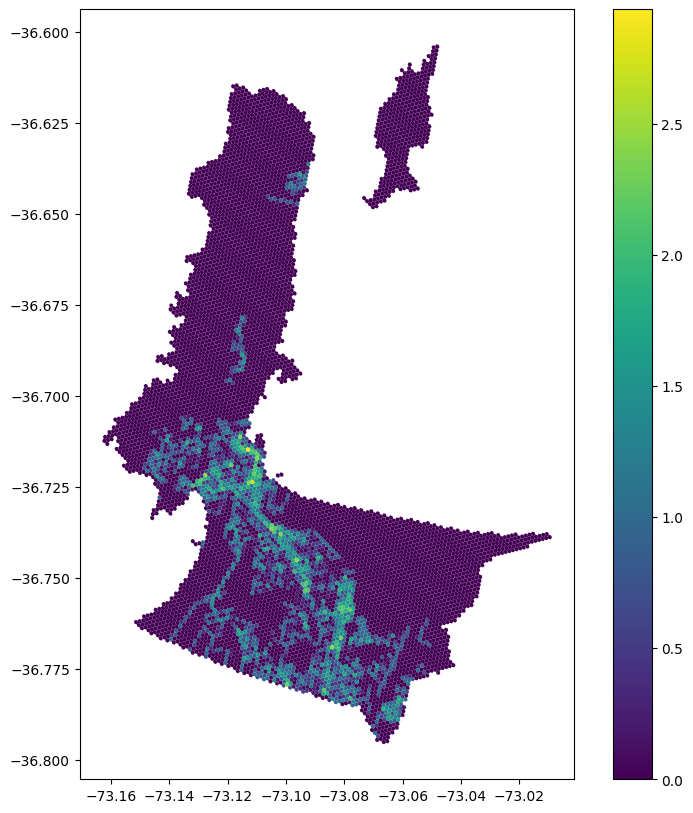

In [136]:
gdf_diversity.plot(column='diversity', legend=True, figsize=(10,10))

In [139]:
gdf_diversity.to_file(f'./data/diversity_{hex_col}')

In [ ]:
# Compress the folder ./data/diversity_hex10 to a zip file
import shutil
shutil.make_archive(f'./data/diversity_{hex_col}', 'zip', f'./data/diversity_{hex_col}')

'c:\\Users\\Asus\\Dev\\talcahuano\\data\\diversity_hex10.zip'

In [142]:
hex_list.to_parquet(f'./data/hex_list_{hex_col}.parquet')

In [145]:
grid_points.to_parquet(f'./data/grid_points_thno.parquet')